In [1]:
import json
import logging
import urllib
from IPython.display import Image as I_note
from IPython.display import display
from IPython.core.display import HTML
from multiprocessing.dummy import Pool as ThreadPool
from time import sleep


import numpy as np
import pytesseract  # need to install using pip
from PIL import Image  # need to install Pillow using pip

In [2]:
from keras.preprocessing import image
from keras.applications.inception_v3 import preprocess_input, decode_predictions, InceptionV3

import numpy as np
import os

# If you want to use a GPU set its index here
os.environ['CUDA_VISIBLE_DEVICES'] = ''

/Users/admin/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
model = InceptionV3(weights='imagenet')

In [19]:
with open('dankmemes.json') as f:
    data = json.load(f)

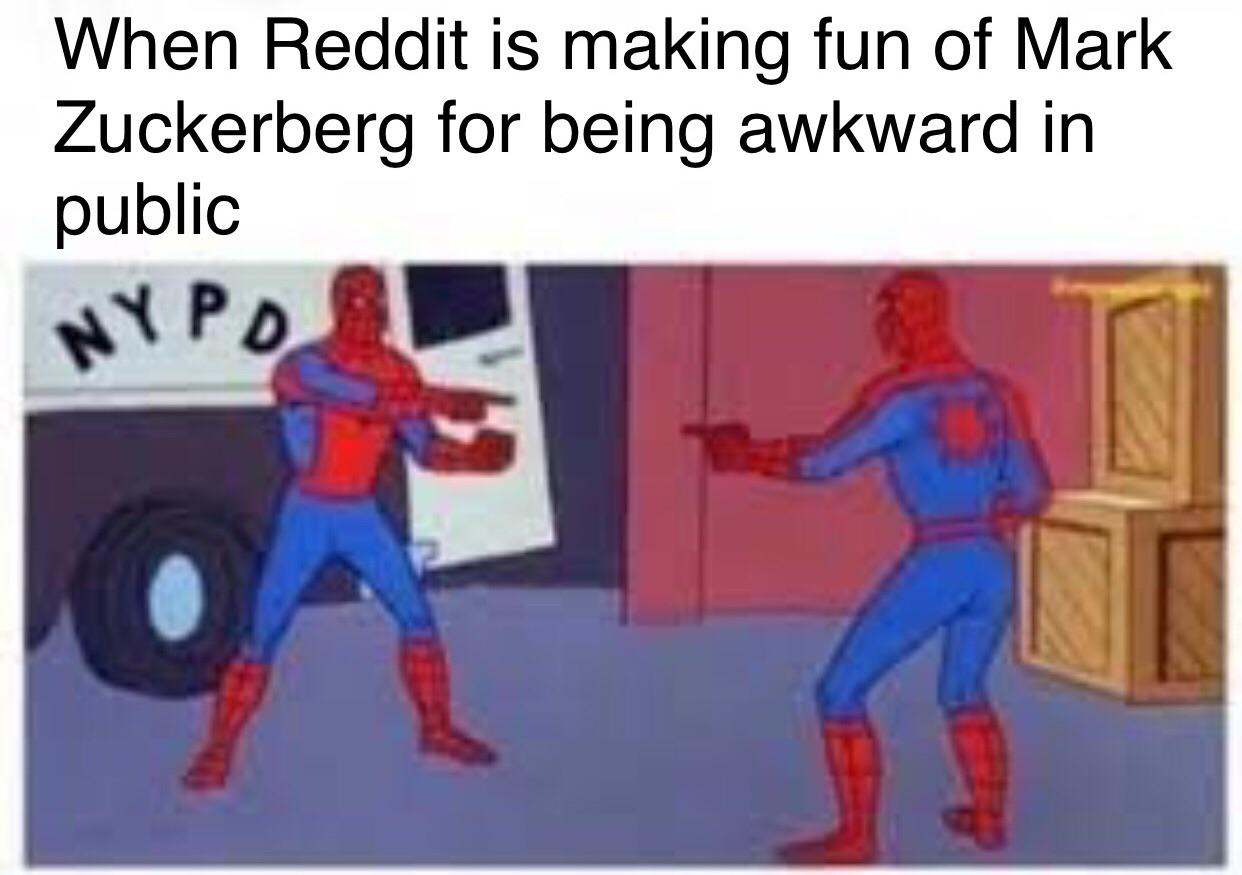

In [26]:
path = download(data[1])
display(I_note(path, width=200, height=200))

In [27]:
text,predictions,title = down_fix(data[1])
print('Text: %s' %text)
print('Title: %s' % title)
print('Predictions: %s' % predictions)

Text: When Reddit is making fun of Mark
Zuckerberg for being awkward in
public

“'0 I
Title: Got ‘em
Predictions: ['comic_book', 'book_jacket', 'jigsaw_puzzle', 'doormat', 'web_site']


972

In [35]:
pool = ThreadPool()
print('Pulling with %s processes' % pool._processes)
results = pool.map(down_fix, data)

Pulling with 8 processes


ERROR:root:Error downloading image. Sleeping two minutes and retrying
ERROR:root:HTTP Error 403: Forbidden
ERROR:root:Retrying
ERROR:root:HTTP Error 403: Forbidden


In [34]:
def fix(meme, image_loc):

    # read in meme data and create image instance
    image = Image.open(image_loc)

    # get text from image and box coords
    text = pytesseract.image_to_string(image)
    box = pytesseract.image_to_boxes(image)

    # make something useful out of shitty return format for box
    spl = box.split('\n')
    coords = []
    lowercase = 'abcdefghijklmnopqrstuvwxyz'
    uppercase = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'
    numbers = '1234567890'
    symbols = "!@#$%&:;<>,.?`/\[]{}()^'" + '"'
    allowable_chars = lowercase + uppercase + numbers + symbols

    # create list of dictionaries with characters and their coordinates
    if len(box) > 1:
        for line in spl:
            chars = line.split(' ')
            char = chars[0]
            if char in allowable_chars:
                coord = {'char': char,
                         'x_start': chars[1],
                         'x_end': chars[3],
                         'y_start': chars[2],
                         'y_end': chars[4]}
                coords.append(coord)

        # create boxes over characters in image
        fixed_image = image.copy()

        # confirm image access
        # if fixed_image.pyaccess:
        color = (255, 255, 255)  # white boxes
        width, height = fixed_image.size
        for dic in coords:
            if int(dic['x_start']) - 2 > 1 and int(dic['x_end']) + 3 < width:
                x_list = np.arange(int(dic['x_start']) - 2, int(dic['x_end']) + 2)
            else:
                x_list = np.arange(int(dic['x_start']) + 1, int(dic['x_end']) - 1)

            if int(dic['y_start']) - 2 > 1 and int(dic['y_end']) + 3 < height:
                y_list = np.arange(int(dic['y_start']) - 2, int(dic['y_end']) + 2)
            else:
                y_list = np.arange(int(dic['y_start']) + 1, int(dic['y_end']) - 1)

            for x in x_list:
                for y in y_list:  # write over pixel with color
                    xy = (x, (height - y))
                    try:
                        fixed_image.putpixel(xy, color)
                    except:
                        pass

        
        fixed_image.save(image_loc, 'PNG')

        # add new file location and text data to dictionary
        return text,image_loc
    else:

        logging.warning('No text found. Skipping')
        
        return None,image_loc
    
def download(meme, url_key='image_url'):
    image_name = meme[url_key].split('/')[-1]
    try:
        urllib.request.urlretrieve(meme[url_key], image_name)
    except urllib.error.HTTPError as e:
        logging.error('Error downloading image. Sleeping two minutes and retrying')
        logging.error(e)
        sleep(10)
        logging.error('Retrying')
        try:
            urllib.request.urlretrieve(meme[url_key], image_name)
        except urllib.error.HTTPError as e:
            logging.error(e)
            return None
            
        
    return image_name

def predict(path):
    img = image.load_img(path, target_size=(299, 299))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    preds = model.predict(x)
    return [m[1] for m in decode_predictions(preds, top=5)[0]]

def down_fix(meme, url_key='image_url', remove=True):
    url = meme[url_key]
    if '.jpg' not in url and not '.png' in url:
        return None, None
    path = download(meme, url_key)
    if not path:
        return None,None,None
    text,path = fix(meme, path)
    predictions = predict(path)
    
    
    if remove:
        os.remove(path)
    return text,predictions, meme['title']